# Setting up the environment

In [ ]:
!pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from collections import namedtuple
import cv2
from tqdm import tqdm
import random
import six
import time
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.python.training import moving_averages
from google.colab.patches import cv2_imshow
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from os.path import isfile, join

In [ ]:
!nvidia-smi

Wed May 12 21:20:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |  15579MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Untaring Jester dataset

In [ ]:
dataset_directory = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data'
content_dir = '/content'

In [ ]:
l = os.listdir(dataset_directory)
nl = []
for s in l:
    if s.startswith('20'):
        nl.append(os.path.join(dataset_directory, s))
nl = sorted(nl)
nl

['/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-00',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-01',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-02',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-03',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-04',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-05',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-06',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1-07',
 '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v

In [ ]:
for s in tqdm(nl):
    !cp "$s" "$content_dir"

  0%|          | 0/24 [00:00<?, ?it/s]

cp: -r not specified; omitting directory '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1'


100%|██████████| 24/24 [09:25<00:00, 23.58s/it]


In [ ]:
!cat 20bn-jester-v1-??  | tar zx 

In [ ]:
len(os.listdir('/content/20bn-jester-v1'))

148092

# Classifier

###Config

In [ ]:
data_dir = '/content/20bn-jester-v1'
#data_dir = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester Data/20bn-jester-v1'
num_frames = 32
resized_shape = (112, 112)
rescale = True

classifier_name = '3D-resnet-101'
classifier_input_shape = (num_frames, resized_shape[0], resized_shape[1], 3)
batch_size = 32

path_out_dir = '/content/Output videos/'
fps = 12.0

## Working with the Dataset

### Extracting Dataset

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-train.csv', delimiter=';', header=None)
df_test = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-test.csv', delimiter=';', header=None)
df_val = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-validation.csv', delimiter=';', header=None)
df_labels = pd.read_csv('/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/Jester CSVs/jester-v1-labels.csv', delimiter=';', header=None)

selected_gestures = set(['Swiping Left', 'Swiping Right', 'Swiping Down', 'Swiping Up', 'Stop Sign', 'No gesture', 'Doing other things'])

train_csv = df_train.to_dict(orient='split')['data']

train_data = {selected_label : [] for selected_label in selected_gestures}
idx_labels = list(sorted(train_data.keys()))
for data in train_csv:
    if data[1] in selected_gestures:
        train_data[data[1]].append((os.path.join(data_dir, str(data[0])),
                                    idx_labels.index(data[1])))


validation_csv = df_val.to_dict(orient='split')['data']
val_data = {selected_label : [] for selected_label in selected_gestures}
for data in validation_csv:
    if data[1] in selected_gestures:
        val_data[data[1]].append((os.path.join(data_dir, str(data[0])),
                                  idx_labels.index(data[1])))

In [ ]:
def find_len(data):
    total=0
    for key in data:
        total += len(data[key])
        print(len(data[key]))
    return total

In [ ]:
print(find_len(train_data))
print()
find_len(val_data)

4162
4337
4084
4220
9592
4278
4259
34932

494
536
486
508
1468
533
520


4545

In [ ]:
def show_vid(path = None, frames = None):
    if frames == None:
        path = os.path.join(data_dir, str(path))
        frames = sorted(os.listdir(path))
    for frame in frames:
        if path != None:
            frame = os.path.join(path, frame)
            frame = cv2.imread(frame)
            cv2_imshow(frame)
        else:
            cv2_imshow(np.array(frame) * 255.)

In [ ]:
def fn_read_frame(rescale):
    def read_frame(frame):
        frame = cv2.imread(frame)
        frame = cv2.resize(frame, resized_shape)
        if rescale: frame = frame/255.
        return frame
    return read_frame

In [ ]:
def extract_frames(path, label, num_frames = num_frames, resized_shape = resized_shape, rescale = True):
    """
    path, label --> path to video directory with all the frames and its label
    output : num_frames which are resized and rescaled if rescaled == True
    """
    frames = [os.path.join(path, frame) for frame in sorted(os.listdir(path))]
    n_frames = len(frames)

    if n_frames > num_frames:
        odd = n_frames % 2
        remove_n_frames = (n_frames - num_frames) // 2
        frames = frames[remove_n_frames : - (remove_n_frames + odd)]
    
    if n_frames < num_frames:
        odd = n_frames % 2
        add_n_frames = (num_frames - n_frames) // 2
        left_frames = frames[:add_n_frames]
        right_frames = frames[-add_n_frames - odd:]
        frames = left_frames + frames + right_frames

    read_frame = fn_read_frame(rescale)
    frames = np.array(list(map(read_frame, frames)))  
    
    if frames.shape == (0,): 
        print(path)

    oh_label = tf.one_hot(int(label), depth = len(idx_labels), dtype=tf.float32)
    
    return (frames, oh_label)

In [ ]:
a = np.arange(9).reshape(3,3).tolist()
b = np.arange(9,18).reshape(3,3).tolist()
b + a

[[9, 10, 11], [12, 13, 14], [15, 16, 17], [0, 1, 2], [3, 4, 5], [6, 7, 8]]

In [ ]:
frames, label = extract_frames(val_data[idx_labels[1]][0][0], val_data[idx_labels[1]][0][1])

tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)


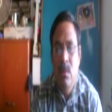

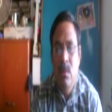

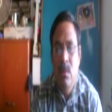

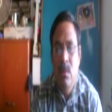

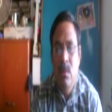

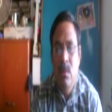

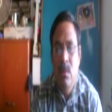

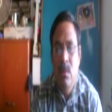

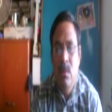

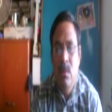

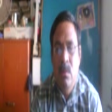

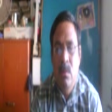

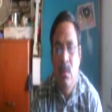

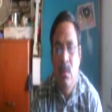

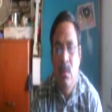

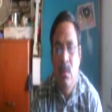

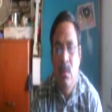

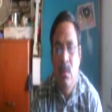

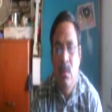

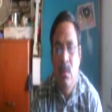

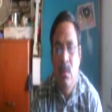

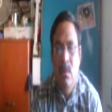

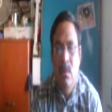

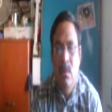

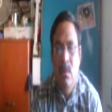

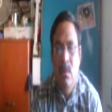

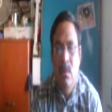

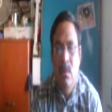

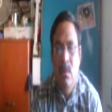

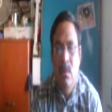

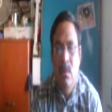

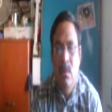

In [ ]:
print(label)
show_vid(frames = frames.tolist())

###tf.data.Dataset

In [ ]:
def get_dataset(data):
    image_paths, labels = [], []
    for key in data:
        for path, label in data[key]:
            image_paths.append(path)
            labels.append(label)
    image_paths, labels = shuffle(image_paths, labels)
    return tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [ ]:
def extract_data(path, label):
    def f(path, label):
        frames, label = extract_frames(path.decode(), label)
        return (frames, label)
    return tf.numpy_function(f, [path, label], [tf.float64, tf.float32])

In [ ]:
train_ds = get_dataset(train_data)
train_ds = train_ds.map(extract_data)

train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(3)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
val_ds = get_dataset(val_data)
val_ds = val_ds.map(extract_data)

val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(3) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [ ]:
i = 0
for x, y in train_ds:
    print(x.shape)
    print(y.shape)
    print(y[0])
    break

(32, 32, 112, 112, 3)
(32, 7)
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32)


## ResNeXt101

### Design Model

In [ ]:
def identity_block(inputs, filters):
    F1, F2, F3 = filters
    bn_axis = 4
    
    x = layers.Conv3D(F1, 3, padding='same')(inputs)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(F2, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(F3, 3, padding='same')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)
    x = layers.add([x, inputs])
    x = layers.Activation('relu')(x)
    
    return x

def conv_block(inputs, filters, stage, strides = (2,2,2)):
    base_name = f'conv_{stage}'
    bn_axis = 4
    F1, F2, F3 = filters
    x = layers.Conv3D(F1, (1, 1, 1), strides = strides,
                        kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv3D(F2, kernel_size=(3, 3, 3), padding = 'same',
                        kernel_initializer = 'he_normal', 
                        name = base_name + '_1')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(F3, kernel_size=(3, 3, 3), padding = 'same',
                        kernel_initializer = 'he_normal', 
                        name = base_name + '_2')(x)
    x = layers.BatchNormalization(axis=bn_axis)(x)
    x = layers.Activation('relu')(x)

    shortcut = layers.Conv3D(F3, (1, 1, 1), strides = strides,
                            kernel_initializer='he_normal')(inputs)
                             
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x



In [ ]:

def build_model(input_dims, F, model_name):
    input_layer = layers.Input(shape=input_dims)
    x = layers.Conv3D(64, (3,3,7), strides = (1, 2, 2),
                            padding='same',
                            name = 'conv1')(input_layer)
    x = layers.BatchNormalization(axis=4)(x)
    x = layers.Activation('relu')(x)
        
    x = layers.MaxPool3D(pool_size=(3,3,3), strides=(2,2,2), 
                            name = 'pool1')(x)

    x = conv_block(x, [128, 128, 256], stage = 2)
    x = identity_block(x, [128, 128, 256])

    x = conv_block(x, [256, 256, 512], stage = 3)
    x = identity_block(x, [256, 256, 512])
    x = identity_block(x, [256, 256, 512])

    x = conv_block(x, [512, 512, 1024], stage = 4)
    x = identity_block(x, [512, 512, 1024])
    
    x = layers.GlobalAveragePooling3D()(x)
    pred = layers.Dense(units = len(idx_labels), activation='softmax')(x)

    return tf.keras.Model(input_layer, pred, name = model_name)


In [ ]:
resnet101 = build_model(classifier_input_shape, 64, classifier_name)

In [ ]:
resnet101.summary()

Model: "3D-resnet-101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 112, 112 0                                            
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 32, 56, 56, 6 12160       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 56, 56, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 56, 56, 6 0           batch_normalization[0][0]        
______________________________________________________________________________________

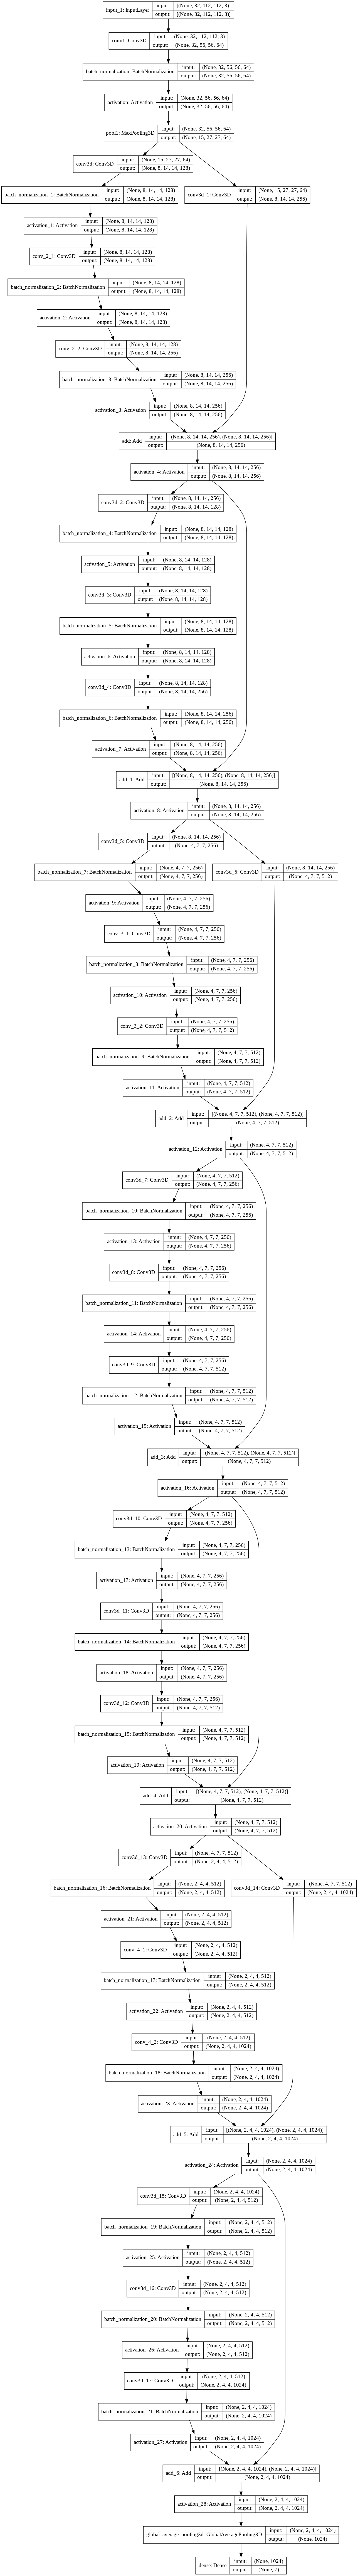

In [ ]:
plot_model(resnet101, show_shapes=True)

### Train Model

In [ ]:
resnet101.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [ ]:
# Create a learning rate scheduler callback.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.2, patience=2, verbose = 1
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=4, restore_best_weights=False
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = f'/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet10_Models/resnet101_7classes.h5',
     monitor = 'val_accuracy', verbose = 1, save_weights_only = True, save_best_only = True
)

In [ ]:
num_epochs = 15

train_ds = get_dataset(train_data)
train_ds = train_ds.map(extract_data)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(3)

val_ds = get_dataset(val_data)
val_ds = val_ds.map(extract_data)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(3) 

callbacks = [reduce_lr, early_stopping, model_checkpoint]


In [ ]:
for x, y in val_ds:
    print(resnet101(x))
    break

Random Guessing Accuracy : around 14.8%

In [ ]:
tf.config.run_functions_eagerly(True)
history = resnet101.fit( 
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=callbacks,
    
)

Epoch 1/15
1092/1092 [==============================] - 2032s 2s/step - loss: 2.0982 - accuracy: 0.3455 - val_loss: 1.5260 - val_accuracy: 0.4493

Epoch 00001: val_accuracy improved from -inf to 0.44928, saving model to /content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet10_Models/resnet101_7classes.h5
Epoch 2/15
1092/1092 [==============================] - 1958s 2s/step - loss: 0.6199 - accuracy: 0.7875 - val_loss: 1.1159 - val_accuracy: 0.5804

Epoch 00002: val_accuracy improved from 0.44928 to 0.58042, saving model to /content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet10_Models/resnet101_7classes.h5
Epoch 3/15
1092/1092 [==============================] - 1925s 2s/step - loss: 0.5127 - accuracy: 0.8282 - val_loss: 0.9532 - val_accuracy: 0.6308

Epoch 00003: val_accuracy improved from 0.58042 to 0.63080, saving model to /content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet10_Models/resnet101_7classes.h5
Epoch 4/15
1092/109

In [ ]:
resnet101.save('3d-resnet-101-7cls')

INFO:tensorflow:Assets written to: 3d-resnet-101-7cls/assets


In [ ]:
resnet101.evaluate(val_ds)

143/143 [==============================] - 205s 1s/step - loss: 0.4536 - accuracy: 0.8590


[0.45357826352119446, 0.8589658737182617]

In [ ]:
!cp -r '/content/3d-resnet-101-7cls' '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet_Models/'

In [ ]:
history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


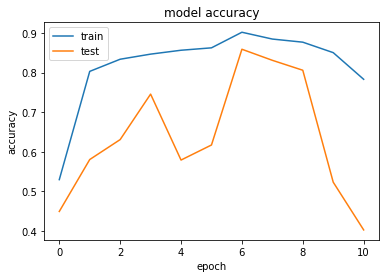

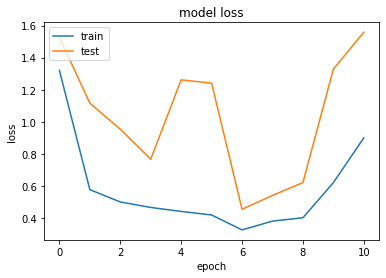

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Eval

In [ ]:
model_path = '/content/drive/MyDrive/Computer Vision/Dynamic Gesture Recognition/resnet10_Models/resnet101_7classes.h5'
#resnet101 = tf.keras.models.load_model(model_path)
resnet101.load_weights(model_path)

In [ ]:
def show_pred(num_examples_of_each = 1):
    n_pos = [num_examples_of_each for i in range(len(idx_labels))]
    n_neg = n_pos[:]
    val_ds = get_dataset(val_data)
    val_ds = val_ds.map(extract_data)
    val_ds = val_ds.batch(8)

    for data in val_ds:
        pred = resnet101.predict(data[0])
        for i, (x, y) in enumerate(zip(data[0], data[1])):
            
            label = np.argmax(y)
            pred_label = np.argmax(pred[i])
            label_in_words = idx_labels[label]
            #return x.numpy().tolist(), label_in_words
            if pred_label == label and n_pos[label] > 0:
                print(f'Showing correctly predicted : {label_in_words}')
                show_vid(frames = x.numpy().tolist())
                n_pos[label] -= 1
            elif pred_label != label and n_neg[label] > 0:
                print(f'Showing wrongly predicted : {label_in_words}')
                print(f'Predicted class : {idx_labels[pred_label]}')
                show_vid(frames = x.numpy().tolist())
                n_neg[label] -= 1
        
        if sum(n_neg) + sum(n_pos) == 0:
            break


In [ ]:
show_pred(3)

Output hidden; open in https://colab.research.google.com to view.